## Нейросети - основы.
### Ноутбук составлен по воспоминаниям из разных курсов, в первую очередь Stanford cs231n

### 1. Простейший классификатор на основе одного нейрона. Градиентный спуск

Попробуем сделать нейрон. n входов, 1 выход, от n входов сигнал передается с весами w, в самом нейроне действует функция активации, работающая с суммой сигналов от входов. Для начала воспользуемся классической сигмоидой. 

Пока реализуем все без numpy, на чистом python. Numpy будем использовать только для функции plot_decision_regions, так как она на входе требует ndarray.

In [1]:
import math

In [2]:
def sigm(x):
    # print(x)
    return 1 / (1 + math.exp(-x))

In [3]:
import matplotlib.pyplot as plt

In [4]:
X = [x for x in range(-10, 10)]

In [5]:
Y = [sigm(x) for x in X]

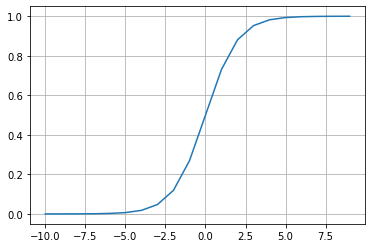

In [6]:
plt.plot(X, Y)
plt.grid()
plt.show()

In [7]:
class Neuron:
    
    def __init__(self, n, activation):
        self.w = [0.5 for i in range(n)] # будем пока пользоваться статической инициализацией весов
        self.act = activation
        
    def forward(self, X):
        result = 0
        for x, w in zip(X, self.w):
            result += x * w
        return self.act(result)

Пусть будет 2 признака, подаваемыми на вход нейрону

In [8]:
X = [-4, 4]

In [9]:
N1 = Neuron(2, sigm)

In [10]:
N1.forward(X)

0.5

В направлении forward работает - теперь нейрон нужно обучить. Возьмем задачу классификации и логистическую функци потерь:

In [11]:
def logloss(y, y_hat):
    eps = 1e-10
    return -y * math.log(y_hat + eps, 2) - (1 - y) * math.log(1 - y_hat + eps, 2)

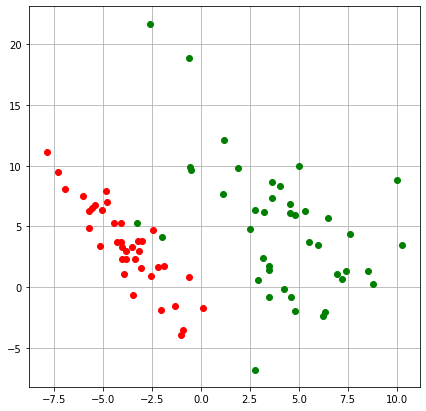

In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X, Y = make_classification(n_samples = 100, n_features = 2, 
                           n_informative = 2, n_classes = 2, 
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           scale = 4,
                           random_state = 2)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=20, random_state = 42)

fig = plt.figure(figsize=(7, 7))

plt.plot(train_X[np.where(train_Y==0), 0], train_X[np.where(train_Y==0), 1], 'ro')
plt.plot(train_X[np.where(train_Y==1), 0], train_X[np.where(train_Y==1), 1], 'go')
plt.grid()

plt.show()

Посмотрим, как выглядит функция ошибки в зависимости от весов w1 и w2

In [13]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [14]:
def makeData(X_train, Y_train):
    W1 = np.arange (-20, 20, 0.4)
    W2 = np.arange (-20, 20, 0.4)
    w1grid, w2grid = np.meshgrid(W1, W2)
    
    lossgrid = np.zeros((len(W1), len(W2)))
    for i, w1 in enumerate(W1):
        for j, w2 in enumerate(W2):
            N = Neuron(2, sigm)
            N.w = [w1, w2]
            result = []
            for x, y in zip(X_train, Y_train):
                y_hat = N.forward(x)
                result.append(logloss(y, y_hat))
            # lossgrid[i, j] = sum(result) / len(result)
            lossgrid[j, i] = sum(result) / len(result)

    return w1grid, w2grid, lossgrid

/tmp/ipykernel_12947/3060583141.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


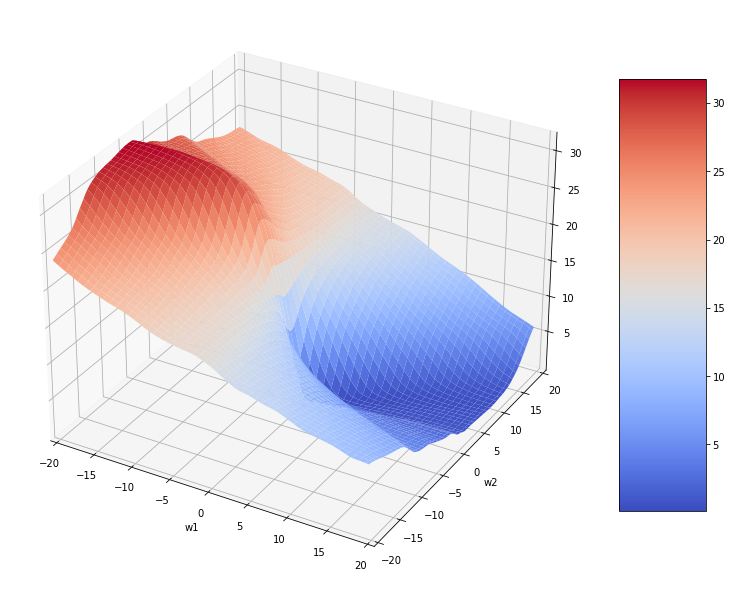

In [15]:
x, y, U = makeData(train_X, train_Y)
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
pylab.show()

In [16]:
U.min()

0.1008400040803403

Необходимо подобрать веса w1 и w2 так, чтобы минимизировать функцию ошибки. На графике выше видно, что минимум находится в районе точки [0, 0]. Если мы инициализируем веса любыми значениями, отличными от оптимальных, необходимо изменять их таким образом, чтобы значение функции ошибки на обучающей выборке снижалось. Оптимальным изменением весов с целью снижения значения функции будет снижение в направлении, противоположном градиенту функции в данной точке. 

Градиент - это вектор-функция, координатами которой являются частные производные. Почему вектор? Потому, что имеет координаты по числу переменных. Почему функция? Потому, что эти координаты зависят от переменных. Градиент функции потерь, представленной на трехмерном графике выше, - это вектор в плоскости (w1, w2).

### $$ gradL(w1, w2) = \left( \frac{\partial(L(w1, w2))}{\partial(w1)}, \frac{\partial(L(w1, w2))}{\partial(w2)} \right) $$
Частные производные показывают скорость роста функции по направлению соответствующей оси. Быстрее всего функция в точке растет в направлении своего градиента. Соответственно, чтобы добиться оптимального снижения значения функции, необходимо двигаться в направлении антиградиента. Как это сделать? Найти частные производные функции потерь по w1 и w2 и двигаться в пространстве (w1, w2) в противоположном этим частным производным направлении шагами определенной величины (learning rate). Это и есть метод градиентного спуска.

Проблема в том, что функция потерь зависит не только от w1 и w2, но и от обучающей выборки. Если бы зависимость от каких-либо переменных, кроме w1 и w2, отсутствовала, мы могли бы аналитически вычислять значение градиента в каждой точке. Или вообще нашли бы значение минимума функции по w1 и w2, приравняв к нулю частные производные. Вместо этого частные производные по переменным придется вычислять, рассчитывая значение функции потерь по обучающей выборке в каждой интересующей нас точке. 

### $$ logloss(y, \hat y) =  -ylog_2(\hat y) - (1-y)(log_2(1-\hat y)) = $$
### $$ = -ylog_2(\frac{1}{1+e^{-(x_1w_1 + x_2w_2)}}) - (1-y)log_2(1- \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}})$$

Частные производные функции потерь по w1 и w2 равны:
### $$\frac{\partial logloss(y, \hat y)}{\partial w_1} = \frac{x_1}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
### $$\frac{\partial logloss(y, \hat y)}{\partial w_2} = \frac{x_2}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
В скобках - разность между выходом нейрона и действительным значением зависимой переменной. Реализуем метод градиентного спуска, пока не стохастический:

Формально правило для изменения весов запишется так:
### $$w:=w - \eta \nabla Q(w) =w = \frac{\eta}{n}\sum_{i=1}^n{\nabla Q_i(w)} $$
, где w - искомый вектор параметров модели, минимизирующий эмпирический риск, 
а сумма берется по всем элементам обучающей выборки. 
Так как w - это вектор, нужно накапливать градиенты по обучающей выборке на каждом шаге отдельно для каждого компонента вектора - переменные w0_sum и w1_sum в алгоритме ниже. 

In [17]:
def gDescent(X_train, Y_train, N1, lr = 0.1, criterion = 0.01, debug = 0):
    curr_loss = 1e3
    iteration = 0
    w0s = []
    w1s = []
    lossfunc = []
    while curr_loss > criterion and iteration < 150:
        
        losses = []
        Y_hat = []
        w1_sum = w2_sum = 0
        
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            w1_sum += x[0] / math.log(2) * (y_hat - y)
            w2_sum += x[1] / math.log(2) * (y_hat - y)
            
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        w0s.append(N1.w[0])
        w1s.append(N1.w[1])
        lossfunc.append(curr_loss)
        
        if debug == 1: print(f'\niteration {iteration}: curr_loss = {curr_loss}, accuracy = {acc}')
        
        N1.w[0] += (-1) * lr * 1 / len(Y_train) * w1_sum # домножаем на -1, так как для поиска минимума мы должны двигаться в направлении, противоположном градиенту
        N1.w[1] += (-1) * lr * 1 / len(Y_train) * w2_sum # домножаем на -1, так как для поиска минимума мы должны двигаться в направлении, противоположном градиенту
        if debug == 1: print(f'new weights: {N1.w}')
        
        iteration += 1
    return w0s, w1s, lossfunc

In [18]:
def accuracy(Y, Y_hat):
    errors = 0
    for y, y_hat in zip(Y, Y_hat):
        if round(y_hat) != y:
            errors += 1
    return (len(Y) - errors) / len(Y)

Создадим примитивный классификатор на основе одного нейрона. Он потребуется, чтобы подать его на вход функции отрисовки decision regions.

In [19]:
class PrimitiveNN:
    
    def __init__(self, Neuron):
        self.N = Neuron
        
    def predict(self, X_test):
        result = []
        for x in X_test:
            result.append(round(self.N.forward(x)))
        return np.array(result)

In [20]:
N1 = Neuron(2, sigm)
N1.w = [-20, -2]

In [21]:
w0s, w1s, lossfunc = gDescent(train_X, train_Y, N1, lr = 0.03, debug = 0)

In [22]:
N1.w

[0.7088649346628064, 0.1822565938422673]

In [23]:
primNN = PrimitiveNN(N1)

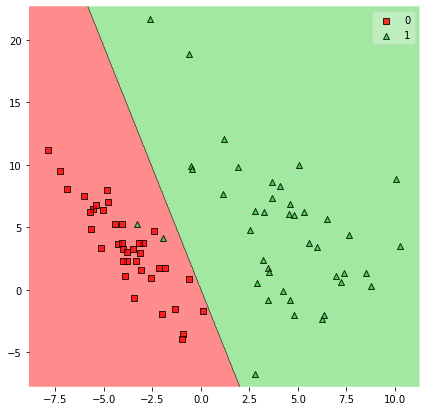

In [24]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, primNN, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Посмотрим, как менялось значение эмпирического риска на каждом шаге обучения

/tmp/ipykernel_12947/519182576.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


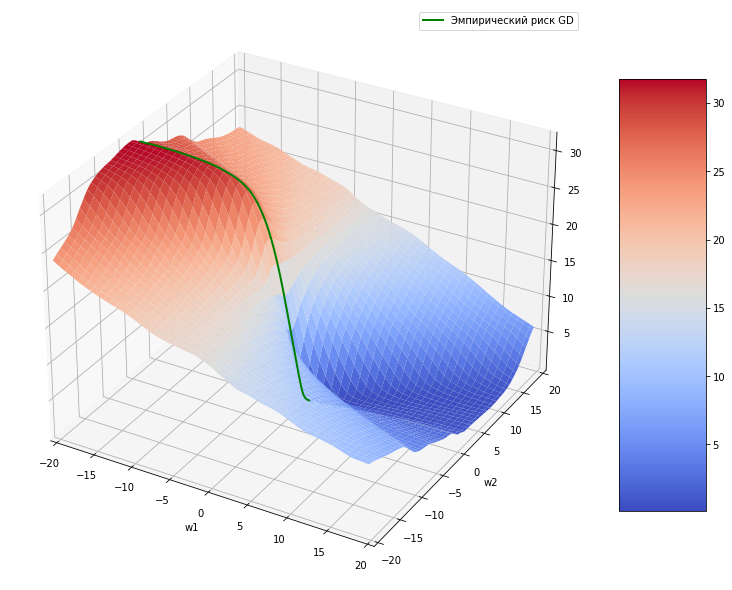

In [25]:
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
axes.plot(np.array(w0s), np.array(w1s), np.array(lossfunc), label='Эмпирический риск GD', color = 'g', linewidth=2, zorder = 10)
axes.legend()
pylab.show()

Реализуем стохастический градиентный спуск. Вместо того, чтобы рассчитывать градиентный шаг, суммируя градиенты по всем экземплярам обучающей выборки, будем случайным образом брать несколько экземпляров обучающей выборки и считать градиентный шаг только по ним. Это позволит ускорить обучение, особенно на больших обучающих выборках.

Для более корректного отображения эмпирического риска на графике, а также чтобы более честно считать accuracy, будем на каждой итерации пересчитывать точность и эмпирический риск по всей обучающей выборке. Градиентный шаг при этом будем рассчитывать, опираясь только на mibi_batch.

In [26]:
import random

def SGD(X_train, Y_train, N1, lr = 0.1, criterion = 0.01, batch_size = 8, debug = 0):
    curr_loss = 1e3
    iteration = 0
    w0s = []
    w1s = []
    lossfunc = []
    while curr_loss > criterion and iteration < 150:
        
        losses = []
        Y_hat = []
        
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        w0s.append(N1.w[0])
        w1s.append(N1.w[1])
        lossfunc.append(curr_loss)
        
        if debug == 1: print(f'\niteration {iteration}: curr_loss = {curr_loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(Y_train))], batch_size)
        w1_sum = w2_sum = 0
        for x, y in zip(X_train[batch_index], Y_train[batch_index]):
            y_hat = N1.forward(x)
            w1_sum += x[0] / math.log(2) * (y_hat - y)
            w2_sum += x[1] / math.log(2) * (y_hat - y)
        
        N1.w[0] += (-1) * lr * 1 / len(batch_index) * w1_sum
        N1.w[1] += (-1) * lr * 1 / len(batch_index) * w2_sum
        if debug == 1: print(f'new weights: {N1.w}')
        
        iteration += 1
    return w0s, w1s, lossfunc

In [27]:
N2 = Neuron(2, sigm)
N2.w = [-20, -2]

In [28]:
w0s, w1s, lossfunc = SGD(train_X, train_Y, N2, lr = 0.03, debug = 0)

In [29]:
N2.w

[0.6902140923256103, 0.1847545835449017]

In [30]:
primNN2 = PrimitiveNN(N2)

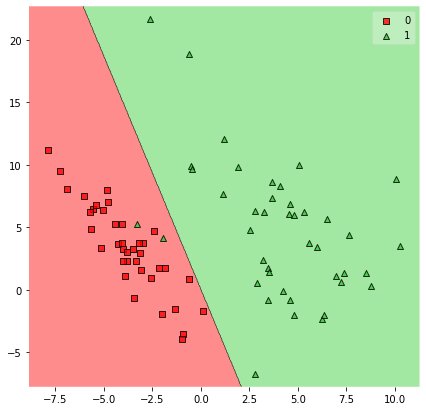

In [31]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, primNN2, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

/tmp/ipykernel_12947/226223530.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


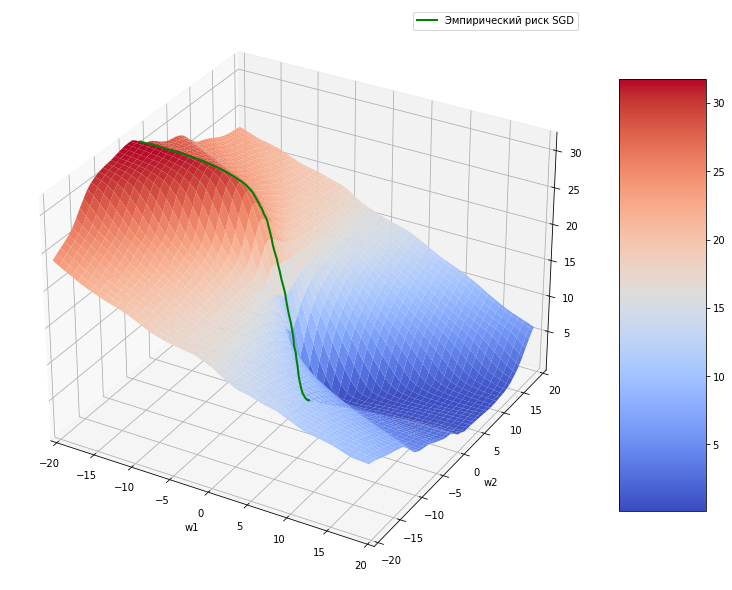

In [32]:
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
axes.plot(np.array(w0s), np.array(w1s), np.array(lossfunc), label='Эмпирический риск SGD', color = 'g', linewidth=2, zorder = 10)
axes.legend()
pylab.show()

Видно, что несмотря на то, что в SGD используется batch размером в 8 экземпляров вместо полного обучающего датасета длиной 80, сходимость обоих алгоритмов практически одинаковая - уровень эмпирического риска меньше 1 достигается в обоих случаях на 116 шаге при идентичной lr = 0.03. По графику SGD видно, что он чуть менее гладкий, но спуск идет по той же траектории в тот же минимум.

### 2. Метод обратного распространения ошибки

Реализуем теперь нейросеть на основе Fully Connected Layers и нелинейных функций активации с помощью numpy. Нейросеть нужно будет делать из компонент - слоев, чтобы можно было последовательно через эти слои запустить forward pass и backward pass. Forward pass аналогичен реализованному выше механизму получения выходного сигнала с единичного нейрона: на вход слоя подается входной сигнал, слой выполняет требуемые преобразования и отдает выходной сигнал, который далее обрабатывается следующим слоем или выдает результат классификации/регрессии, на основе которого рассчитывается ошибка. 

Концепция backward pass сложнее. Для обучения нейросети методом градиентного спуска необходимо уметь рассчитывать частные производные от функции потерь по каждому параметру неросети, чтобы делать градиентный шаг. Производные по параметрам можно рассчитать аналитически, но для крупной нейросети аналитический расчет будет недопустимо сложным. Альтернативным методом расчета градиентов является механизм обратного распространения ошибки backpropagation, основанный на т.н. chain rule, или правиле взятия производной сложной функции. 

### $$\frac{\partial f(y(x))}{\partial x} = \frac{\partial f(y)}{\partial y(x)}\frac{\partial y(x)}{\partial x}$$

При проходе forward pass каждый последующий слой нейросети принимает на вход сигнал от предыдущего слоя, выполняет преобразование в соответствии со своей логикой и передает выходной сигнал дальше по сети. Соответственно, частную производную по какому-либо параметру в текущем слое можно рассчитать через произведение "входящего" градиента (частная производная функции потерь по выходу из рассматриваемого слоя) и градиента функции в рассматриваемом слое по искомому параметру.

При прохождении backward pass кроме частных производных по параметрам рассматриваемого слоя необходимо рассчитывать частные производные по входам с предыдущего уровня. Именно эти производные станут "входящими" для расчета градиентов на предыдущем уровне. 

Релизуем линейный слой (Fully Connected Layer) с учетом описанной логики. Пусть на вход линейного слоя подается batch размером N, каждый экземпляр выборки представлен D-признаками. Пусть выход линейного слоя представлен M - нейронами. Тогда на выходе слоя будем получать batch размером N x M. Соответственно, веса линейного слоя образуют матрицу W размерностью (D x M)

В рамках механизма backpropagation необходимо рассчитать два вида градиентов:
### $$ \frac{\partial L(X, W)}{\partial W} $$
для расчета градиентного шага и 
### $$ \frac{\partial L(X, W)}{\partial X} $$
для передачи градиентов на предыдущий слой

Для расчета обеих матриц необходимо знать "входящий" градиент, т.е., производную функции потерь по выходу из рассматриваемого слоя. Обозначим выход из нашего линейного слоя Y, его размерность будет N x M. Так как значение функции потерь - это скаляр, его производная по матрице Y будет иметь ту же размерность, что и сама матрица Y. То есть, на вход нашего линейного слоя в рамках механизма backpropagation мы должны получить матрицу
### $$ \frac{\partial L}{\partial Y} = \begin{pmatrix} \frac{\partial L}{\partial y_{1,1}}&. . .&\frac{\partial L}{\partial y_{1,M}}\\\frac{\partial L}{\partial y_{N,1}}&. . .& \frac{\partial L}{\partial y_{N,M}}\end{pmatrix}$$

Дальше, пользуясь chain rule, получим

### $$\frac{\partial L(X, W)}{\partial W} = \frac{\partial L(X, W)}{\partial Y}\frac{\partial Y}{\partial W} $$
### $$\frac{\partial L(X, W)}{\partial X} = \frac{\partial L(X, W)}{\partial Y}\frac{\partial Y}{\partial X} $$
где $\frac{\partial Y}{\partial W}$ и $\frac{\partial Y}{\partial X}$ - Якобианы, содержащие частные производные каждого компонента матрицы Y по каждому компоненту матриц X и W соответственно.

С Якобианами в общем виде работать непрактично ввиду их разреженности и большого размера, поэтому (здесь без вывода, вывод в конспекте) для частных производных по X и по W линейного слоя используются готовые формулы:
### $$\frac{\partial L(X, W)}{\partial W} = X^T\frac{\partial L(X, W)}{\partial Y}$$
### $$\frac{\partial L(X, W)}{\partial X} = \frac{\partial L(X, W)}{\partial Y}W^T$$

In [33]:
class Linear:
    
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        self.W = np.random.default_rng().uniform(-0.5, 0.5, (inp, out))
        self.X_ = None # кэш для хранения входов с предыдущего уровня для расчета градиентов на backward pass
        
    def forward(self, X):
        self.X_ = X
        return np.dot(X, self.W)
    
    def backward(self, upstr_grad, lr = 0.01): #upstr_grad - входящий градиент от уровня, находящегося ближе к выходу нейросети
        delta_W = np.dot(np.transpose(self.X_), upstr_grad)
        self.W += (-1) * lr * delta_W # домножаем на -1, так как необходимо идти в противоположную от градиента сторону
        return np.dot(upstr_grad, np.transpose(self.W))

In [34]:
LL = Linear(2, 3)

In [35]:
LL.W

array([[-0.09922713,  0.30408031, -0.08975316],
       [ 0.11284728,  0.2488304 , -0.06721871]])

In [36]:
X = np.array([[1, 2], [3, 4]])

In [37]:
LL.forward(X)

array([[ 0.12646743,  0.80174112, -0.22419059],
       [ 0.15370773,  1.90756254, -0.53813435]])

In [38]:
UG = np.array([[1, 2, 3],[4, 5, 6]])

In [39]:
LL.backward(UG)

array([[-0.860326  , -1.15114806],
       [-2.04502595, -2.42777115]])